# Dynamic motion planning
1). Build exploring tree
2). Maintain tree

In [1]:
from eval_gnn import eval_gnn
from str2env import str2env
import numpy as np
import torch
from time import time
from torch_geometric.data import Data
from config import set_random_seed
from tqdm import tqdm as tqdm
from torch_sparse import coalesce
from torch_geometric.nn import knn_graph
import matplotlib.pyplot as plt
import networkx as nx

loop = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/wenjin/anaconda3/envs/gnnmp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [2]:
def to_np(tensor):
    return tensor.data.cpu().numpy()

def to_tuple(array):
    array = np.array(torch.FloatTensor(array))
    return tuple(array.reshape(1, -1)[0])

def to_nparray(t):
    array = torch.FloatTensor(array)
    return np.array(t).reshape(1, -1)[0]

In [3]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    
def obs_data(env, free, collided):
    data = DotDict({
        'free': torch.FloatTensor(np.array(free)).to(device),
        'collided': torch.FloatTensor(np.array(collided))[:len(free)].to(device),
        'obstacles': torch.FloatTensor(env.obstacles).to(device),
    })
    return data

In [4]:
# test on new environment
from config import set_random_seed
from str2name import str2name


from environment import MazeEnv
env = MazeEnv(dim=2, map_file='maze_files/mazes_hard_.npz')
indexes = range(0, 1000)
bs = 100  # only sample 100 points

env.init_new_problem(4)
set_random_seed(1234)
_, model, model_path, model_s, model_s_path = str2name(str(env))

# result = explore(env, model, model_s, smooth=True, smoother='model', batch=bs, t_max=bs, k=10)


In [5]:
def create_data(free, collided, env, k):
    data = Data(goal=torch.FloatTensor(env.init_state))
    
    # graph vertices start point + end point + free + collied
    data.v = torch.cat((torch.FloatTensor(np.array(free)),
                        torch.FloatTensor(np.array(collided))), dim=0)

    # create labels
    data.labels = torch.zeros(len(data.v), 3)
    #  the vertices in the free space
    data.labels[:len(free), 0] = 1
    #  the vertices with collision
    data.labels[len(free):, 1] = 1
    # goal vertex
    data.labels[1, 2] = 1
    k1 = int(np.ceil(k * np.log(len(free)) / np.log(100)))
    edge_index = knn_graph(torch.FloatTensor(data.v), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index.flip(0)), dim=-1)
    edge_index_free = knn_graph(torch.FloatTensor(data.v[:len(free)]), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index_free, edge_index_free.flip(0)), dim=-1)
    data.edge_index, _ = coalesce(edge_index, None, len(data.v), len(data.v))

    return data

In [8]:
from smoother import model_smooth, proposed_path_smoother, joint_smoother, interpolate_path

def explore_graph(env, explore_model, batch=500, t_max = 1000, k = 10, smooth=True, smoother='model'):
    batch=500
    t_max=1000 
    k=30
    loop=5

    c0 = env.collision_check_count
    t0 = time()
    forward = 0

    success = False
    path = []

    free, collided = env.sample_n_points(batch, need_negative=True)
    collided = collided[:len(free)]
    free = [env.goal_state] + [env.init_state] + list(free)

    # initial search
    explored = [0]
    explored_edges = [[0, 0]]
    prev = {0: 0}
    G = nx.Graph()
    data = create_data(free, collided, env, k)

    # add goal point into graph (vertices is the explored points. explore from goal point)
    node_goal = to_tuple(env.goal_state)
    node_start = None

    while not success and (len(free) - 2) <= t_max:
        t1 = time()
        policy = explore_model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)
        policy = policy.cpu()
        forward += time() - t1

        policy[torch.arange(len(data.v)), torch.arange(len(data.v))] = 0
        policy[:, explored] = 0
        policy[:, data.labels[:, 1] == 1] = 0
        policy[data.labels[:, 1] == 1, :] = 0
        policy[np.array(explored_edges).reshape(2, -1)] = 0
        success = False
        while policy[explored, :].sum() != 0:
            agent = policy[np.array(explored)[torch.where(policy[explored, :] != 0)[0]], torch.where(policy[explored, :] != 0)[1]].argmax()
            end_a, end_b = torch.where(policy[explored, :] != 0)[0][agent], torch.where(policy[explored, :] != 0)[1][agent]
            end_a, end_b = int(end_a), int(end_b)
            end_a = explored[end_a]
            explored_edges.extend([[end_a, end_b], [end_b, end_a]])
            
            state_a, state_b = to_np(data.v[end_a]), to_np(data.v[end_b])

            if env._edge_fp(state_a, state_b):
                explored.append(end_b)
                prev[end_b] = end_a
                tmp_a, tmp_b = to_tuple(state_a), to_tuple(state_b)
                G.add_edge(tmp_a, tmp_b, weight=np.linalg.norm(state_a - state_b))
                
                policy[:, end_b] = 0

                if env.in_start_region(state_b):
                    node_start = tmp_b
                    success = True
                    path = [end_b]
                    node = end_b
                    while node != 0:
                        path.append(prev[node])
                        node = prev[node]
                    path.reverse()
                    break
            else:
                policy[end_a, end_b] = 0
                policy[end_b, end_a] = 0

        if not success:
            if (batch + len(free) - 2) > t_max:
                break
            # ----------------------------------------resample----------------------------------------
            new_free, new_collided = env.sample_n_points(batch, need_negative=True)
            free = free + list(new_free)
            collided = collided + list(new_collided)
            collided = collided[:len(free)]
            data = create_data(free, collided, env, k)
        else:
            path = list(data.v[path].data.cpu().numpy())

    c_explore = env.collision_check_count - c0
    explored_graph = G

    if success and smooth:
        # path = list(data.v[path].data.cpu().numpy())
        if smoother == 'model':
            smooth_path = model_smooth(model_s, free, collided, path, env)
        elif smoother == 'oracle':
            smooth_path = joint_smoother(path, env, iter=5)
        else:
            smooth_path = path
    
    return explored_graph, explored_edges, path, data, node_start, node_goal, smooth_path


In [9]:
explored_graph, explored_edges, path, data, node_start, node_goal, smooth_path= explore_graph(env, explore_model=model)

<Figure size 640x480 with 0 Axes>

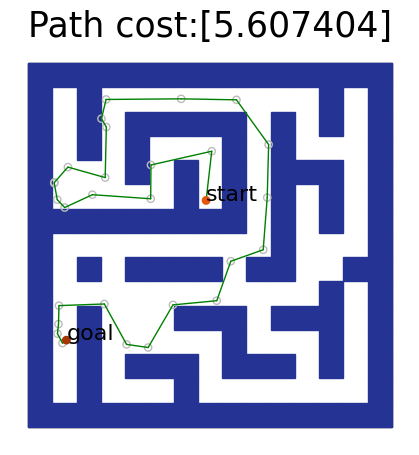

In [10]:
from utils.plot import plot_edges, plot_env_only, plot_optimization_edges
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges

edges = data.v[np.array(explored_edges).reshape(-1) ].reshape(-1, 2, 2)

edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
distance = env.path_distance(path)
plot_optimization_edges(path, edges, env.get_problem(), \
           title='Path cost:{}'.format(distance), \
           save=None)
plt.show()

In [11]:
from utils.plot import draw_edge, draw_node
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_graph(G, env, optim_path=[], edge_classes=None, title='Figure', title_size=25, show_edge = True):
    nodes = [np.array(x) for x in list(G.nodes)]
    edges = [(np.array(x), np.array(y)) for (x, y) in list(G.edges)] 
    # plt.clf()
    problem = env.get_problem()
    environment_map = problem["map"]
    init_state = problem["init_state"]
    goal_state = problem["goal_state"]
    dim = init_state.size

    fig = plt.figure(figsize=(4, 4))

    rect = patches.Rectangle((0.0, 0.0), 2.0, 2.0, linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rect)

    map_width = environment_map.shape
    d_x = 2.0 / map_width[0]
    d_y = 2.0 / map_width[1]
    for i in range(map_width[0]):
        for j in range(map_width[1]):
            if environment_map[i, j] > 0:
                rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#253494',
                                         facecolor='#253494')
                plt.gca().add_patch(rect)


    moving_obstacles = env.moving_obstacles

    for (i, j) in moving_obstacles:
        [i, j] = env._transform([i, j])
        print("moving obstcles is ({},{})".format(i, j))
        rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#942525', facecolor='#942525')
        plt.gca().add_patch(rect)

    for i in range(len(nodes)):
        draw_node(nodes[i], '#bbbbbb', dim=dim)
        # plt.annotate('{}'.format(i), states[i]+1.0, color='black', fontsize=20)

    if show_edge:
        for i in range(len(edges)):
            draw_edge(edges[i][0], edges[i][1], 'green', dim=dim)
    
    if len(optim_path) > 1:
        for i in range(len(optim_path) - 1):
            draw_edge(np.array(optim_path[i]), np.array(optim_path[i+1]), 'red', dim=dim)
        
    draw_node(init_state, '#e6550d', dim=dim, face=True)
    draw_node(goal_state, '#a63603', dim=dim, face=True)
    
    plt.annotate('start', init_state+1.0, color='black', fontsize=16)
    plt.annotate('goal', goal_state+1.0, color='black', fontsize=16)

    plt.axis([0.0, 2.0, 0.0, 2.0])
    # plt.axis('off')
    plt.axis('square')
    plt.gca().invert_yaxis()

    plt.subplots_adjust(left=-0., right=1.0, top=1.0, bottom=-0.)

    distance = env.path_distance(optim_path)
    plt.title('Path cost:{}'.format(distance), fontdict = {'fontsize':title_size})
    # plt.show()


def plot_graph_withnodes(G, env, optim_path=[], othernodes=[], title_size=25, show_edge = True):
    nodes = [np.array(x) for x in list(G.nodes)]
    edges = [(np.array(x), np.array(y)) for (x, y) in list(G.edges)] 
    # plt.clf()
    problem = env.get_problem()
    environment_map = problem["map"]
    init_state = problem["init_state"]
    goal_state = problem["goal_state"]
    dim = init_state.size

    fig = plt.figure(figsize=(4, 4))

    rect = patches.Rectangle((0.0, 0.0), 2.0, 2.0, linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rect)

    map_width = environment_map.shape
    d_x = 2.0 / map_width[0]
    d_y = 2.0 / map_width[1]
    for i in range(map_width[0]):
        for j in range(map_width[1]):
            if environment_map[i, j] > 0:
                rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#253494',
                                         facecolor='#253494')
                plt.gca().add_patch(rect)


    moving_obstacles = env.moving_obstacles

    for (i, j) in moving_obstacles:
        [i, j] = env._transform([i, j])
        print("moving obstcles is ({},{})".format(i, j))
        rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#942525', facecolor='#942525')
        plt.gca().add_patch(rect)

    for i in range(len(nodes)):
        draw_node(nodes[i], '#bbbbbb', dim=dim)
        # plt.annotate('{}'.format(i), states[i]+1.0, color='black', fontsize=20)
    
    for i in range(len(othernodes)):
        draw_node(othernodes[i], '#14ba11', dim=dim)


    if show_edge:
        for i in range(len(edges)):
            draw_edge(edges[i][0], edges[i][1], 'green', dim=dim)
    
    if len(optim_path) > 1:
        for i in range(len(optim_path) - 1):
            draw_edge(np.array(optim_path[i]), np.array(optim_path[i+1]), 'red', dim=dim)
        
    draw_node(init_state, '#e6550d', dim=dim, face=True)
    draw_node(goal_state, '#a63603', dim=dim, face=True)
    
    plt.annotate('start', init_state+1.0, color='black', fontsize=16)
    plt.annotate('goal', goal_state+1.0, color='black', fontsize=16)

    plt.axis([0.0, 2.0, 0.0, 2.0])
    # plt.axis('off')
    plt.axis('square')
    plt.gca().invert_yaxis()

    plt.subplots_adjust(left=-0., right=1.0, top=1.0, bottom=-0.)

    distance = env.path_distance(optim_path)
    plt.title('Path cost:{}'.format(distance), fontdict = {'fontsize':title_size})
    # plt.show()

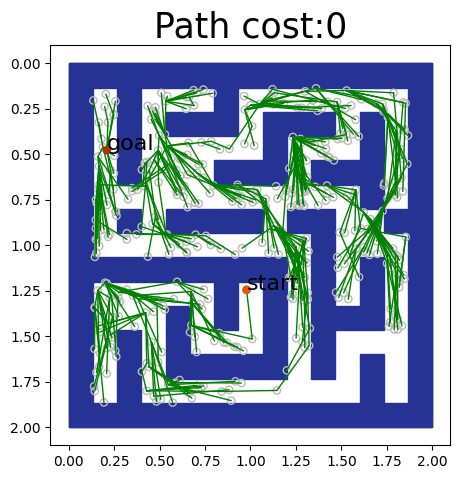

In [12]:
plot_graph(explored_graph, env)

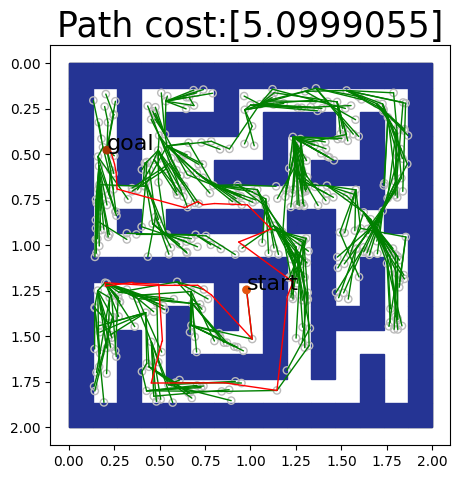

In [13]:
plot_graph(explored_graph, env, optim_path=smooth_path)

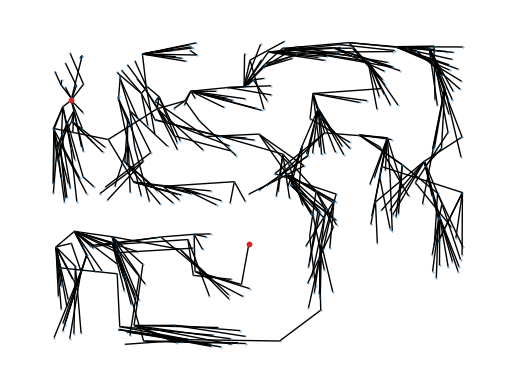

In [ ]:
from matplotlib import pyplot
pyplot.gca().invert_yaxis()


for node in explored_graph.nodes:
    explored_graph.nodes[node]['pos'] = node

nx.draw(explored_graph, nx.get_node_attributes(explored_graph, 'pos'), node_size=0.1)
nx.draw_networkx_nodes(explored_graph, nx.get_node_attributes(explored_graph, 'pos'), nodelist=[node_start, node_goal], node_color="tab:red", node_size=10)

In [ ]:
def get_optimal_path(G):
    from copy import deepcopy
    graph = deepcopy(G)

    number_nodes = len(graph.nodes)
    nodes = list(graph.nodes)
    # graph nodes in grapj
    nodes = sorted(nodes, key=lambda node: np.linalg.norm(np.array(node) - np.array(node_goal)))

    count = 0
    for i in range(number_nodes):
        collision = 0
        for j in range(number_nodes-1, i, -1):
            node_x, node_y = nodes[i], nodes[j]
            if not graph.has_edge(node_x, node_y):
                if env._edge_fp(np.array(node_x), np.array(node_y)):
                    graph.add_edge(node_x, node_y, weight=np.linalg.norm(np.array(node_x) - np.array(node_y)))
                    count = count + 1
                    break

    

    optim_path = nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight")
    # check whether we can skip nodes
    final_path = deepcopy(optim_path)
    n = len(optim_path)
    for i in range(n):
        for j in range(n - 1, i + 1, -1):
            node_x, node_y = optim_path[i], optim_path[j]
            if not graph.has_edge(node_x, node_y):
                if env._edge_fp(np.array(node_x), np.array(node_y)):
                    graph.add_edge(node_x, node_y, weight=np.linalg.norm(np.array(node_x) - np.array(node_y)))
                    count = count + 1
                    break

    # no need run dijkstra again need improve later
    final_path = nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight")

    print("add {} edges".format(count))
    print(final_path)
    return final_path, graph


add 435 edges
[(-0.039037015, 0.28785285), (-0.063976504, 0.5804555), (-0.12454452, 0.57071716), (-0.32965067, 0.31510356), (-0.6169611, 0.24421754), (-0.5241297, 0.7435693), (0.09130372, 0.8310904), (0.26524663, 0.6575013), (0.32847694, 0.04668996), (-0.42669788, -0.015229589), (-0.787079, -0.40568203), (-0.78993815, -0.5232715)]


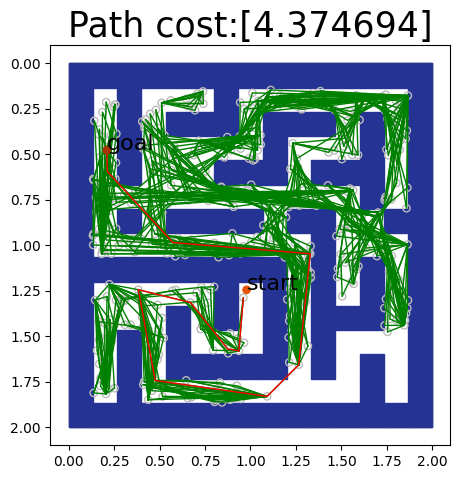

In [ ]:
optimal_path, G = get_optimal_path(explored_graph)
plot_graph(G, env, optim_path=optimal_path)

# Dynamic environment
Moves obstcles
Manually add obstcles to test the dynamic planning method

Moving to next location
### case 1: The new block won't affect the feasible path. Nothing need to do with the planing path

### case 2: The new block block the fesible path. Requrie to maintain the exploring tree


In [ ]:
# in this case add obstacles can block the current optimal path
from copy import deepcopy
old_map = deepcopy(env.map)
env.add_moving_obstacles([[9, 9]])
new_map = deepcopy(env.map)

add node(9, 9)
now node(9, 9) is map:1.0


moving obstcles is (9,9)


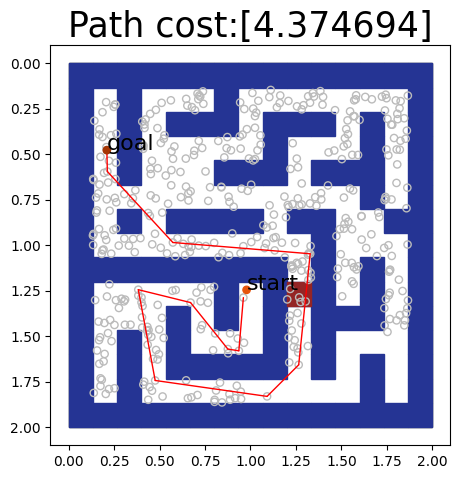

In [ ]:
plot_graph(G, env, optim_path=optimal_path, show_edge=False)

moving obstcles is (9,9)


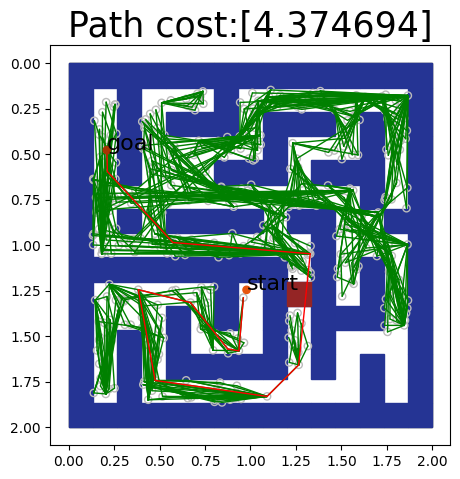

In [ ]:
def invalid_graph(graph, old_map, new_map):
    new_graph = deepcopy(graph)
    new_free = []
    new_collision = []
    map_width = old_map.shape
    for i in range(map_width[0]):
        for j in range(map_width[1]):
            if old_map[i,j] != new_map[i, j]:
                if old_map[i,j] == 1:
                    new_free.append((i,j))
                else:
                    new_map[i,j] == 1
                    new_collision.append((i,j))
    
    # threshold to eheck whether is in the region.
    dx = 1 / map_width[0]
    collision_threshold = dx*1.5
    # to grante. It should be the longest edge
    nearby_threshold = collision_threshold * 5
    # check collison node one by one 
    for obs_node in new_collision:
        obs_state = env._inverse_transform(obs_node) + dx
        collision_nodes = [x for x in list(G.nodes) if env.distance(x, obs_state) < collision_threshold]
        nearby_nodes = [x for x in list(G.nodes) if env.distance(x, obs_state) < nearby_threshold and env.distance(x, obs_state) > collision_threshold]
        new_graph.remove_nodes_from(collision_nodes)

        for i in range(len(nearby_nodes)):
            for j in range(i + 1, len(nearby_nodes)):
                node_a, node_b = nearby_nodes[i], nearby_nodes[j]
                # only check collison when graph has connection and edge cross the obstacles
                if new_graph.has_edge(node_a, node_b) and env.distance(np.array(node_a), np.array(node_b)) > dx:
                    state_a, state_b = np.array(node_a), np.array(node_b)
                    if not env._edge_fp(state_a, state_b):
                        new_graph.remove_edge(node_a, node_b)
        
        
    # plot_graph(new_graph, env, optim_path=optimal_path)

    # collision_nodes = [np.array(x) for x in collision_nodes]
    # nearby_nodes = [np.array(x) for x in nearby_nodes]
    # plot_graph_withnodes(new_graph, env, optim_path=optimal_path, othernodes=nearby_nodes, show_edge=False)
    return new_graph
        

valid_graph = invalid_graph(G, old_map, new_map)
plot_graph(valid_graph, env, optim_path=optimal_path)

Chanllenge: how to quickly check whether the graph is connected? It is unwised to check the whole graph for each iteration. Time O(N)

- 考虑连通分量：goal 对应一个subgraph. start对应一个subgraph. We only need to find a branch connect two subgraph (Using hashmap) Time O(1)



In [ ]:
# rewire graph
# sampling new node
def repair_graph(env, explore_model, batch=200, t_max = 1000, k = 10):
    c0 = env.collision_check_count

    success = False
    path = []

    free, collided = env.sample_n_points(batch, need_negative=True)
    collided = collided[:len(free)]
    free = [env.goal_state] + [env.init_state] + list(free)

    # initial search
    explored = [0]
    explored_edges = [[0, 0]]
    prev = {0: 0}
    G = nx.Graph()
    data = create_data(free, collided, env, k)

    # add goal point into graph (vertices is the explored points. explore from goal point)
    node_goal = to_tuple(env.goal_state)
    node_start = None

    while not success and (len(free) - 2) <= t_max:
        t1 = time()
        policy = explore_model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)
        policy = policy.cpu()
        forward += time() - t1

        policy[torch.arange(len(data.v)), torch.arange(len(data.v))] = 0
        policy[:, explored] = 0
        policy[:, data.labels[:, 1] == 1] = 0
        policy[data.labels[:, 1] == 1, :] = 0
        policy[np.array(explored_edges).reshape(2, -1)] = 0
        success = False
        while policy[explored, :].sum() != 0:
            agent = policy[np.array(explored)[torch.where(policy[explored, :] != 0)[0]], torch.where(policy[explored, :] != 0)[1]].argmax()
            end_a, end_b = torch.where(policy[explored, :] != 0)[0][agent], torch.where(policy[explored, :] != 0)[1][agent]
            end_a, end_b = int(end_a), int(end_b)
            end_a = explored[end_a]
            explored_edges.extend([[end_a, end_b], [end_b, end_a]])
            
            state_a, state_b = to_np(data.v[end_a]), to_np(data.v[end_b])

            if env._edge_fp(state_a, state_b):
                explored.append(end_b)
                prev[end_b] = end_a
                tmp_a, tmp_b = to_tuple(state_a), to_tuple(state_b)
                G.add_edge(tmp_a, tmp_b, weight=np.linalg.norm(state_a - state_b))
                
                policy[:, end_b] = 0

                if env.in_start_region(state_b):
                    node_start = tmp_b
                    success = True
                    path = [end_b]
                    node = end_b
                    while node != 0:
                        path.append(prev[node])
                        node = prev[node]
                    path.reverse()
                    break
            else:
                policy[end_a, end_b] = 0
                policy[end_b, end_a] = 0

        if not success:
            if (batch + len(free) - 2) > t_max:
                break
            # ----------------------------------------resample----------------------------------------
            new_free, new_collided = env.sample_n_points(batch, need_negative=True)
            free = free + list(new_free)
            collided = collided + list(new_collided)
            collided = collided[:len(free)]
            data = create_data(free, collided, env, k)
        else:
            path = list(data.v[path].data.cpu().numpy())

    c_explore = env.collision_check_count - c0
    explored_graph = G
    
    return explored_graph, explored_edges, path, data, node_start, node_goal


### case 3: The blocker moves to another plan. The better path is available. 